In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
base_dir = "dataset"

train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

classes = ["Baroque paintings", "Medieval art", "Renaissance paintings"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

IMG_SIZE = 128

In [4]:
def load_images_from_folder(folder, label_index):
    images = []
    labels = []

    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)

        img = cv2.imread(path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        images.append(img)
        labels.append(label_index)

    return np.array(images), np.array(labels)

In [5]:
X_train_all = []
y_train_all = []

for cls in classes:
    folder_path = os.path.join(train_dir, cls)
    imgs, lbls = load_images_from_folder(folder_path, class_to_idx[cls])

    X_train_all.append(imgs)
    y_train_all.append(lbls)

X_train_all = np.concatenate(X_train_all)
y_train_all = np.concatenate(y_train_all)

print("Train images loaded:", X_train_all.shape)

Train images loaded: (305, 128, 128, 3)


In [6]:
X_test = []
y_test = []

for cls in classes:
    folder_path = os.path.join(test_dir, cls)
    imgs, lbls = load_images_from_folder(folder_path, class_to_idx[cls])

    X_test.append(imgs)
    y_test.append(lbls)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Test images loaded:", X_test.shape)

Test images loaded: (147, 128, 128, 3)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, 
    test_size=0.2, random_state=42, stratify=y_train_all
)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (244, 128, 128, 3) Val: (61, 128, 128, 3)


In [8]:
num_classes = 3

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\Alicee\anaconda3\envs\cv_project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.3852 - loss: 1.1124 - val_accuracy: 0.5082 - val_loss: 1.0201
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5902 - loss: 0.9733 - val_accuracy: 0.6066 - val_loss: 0.8909
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5943 - loss: 0.8594 - val_accuracy: 0.6066 - val_loss: 0.7935
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6680 - loss: 0.7421 - val_accuracy: 0.6393 - val_loss: 0.7663
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7377 - loss: 0.6509 - val_accuracy: 0.6066 - val_loss: 0.7937
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7377 - loss: 0.6119 - val_accuracy: 0.6066 - val_loss: 0.7948
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7951 - loss: 0.5427 - val_accuracy: 0.6393 - val_loss: 0.7690
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8525 - loss: 0.4357 - val_accuracy: 0.6066 - val_loss:

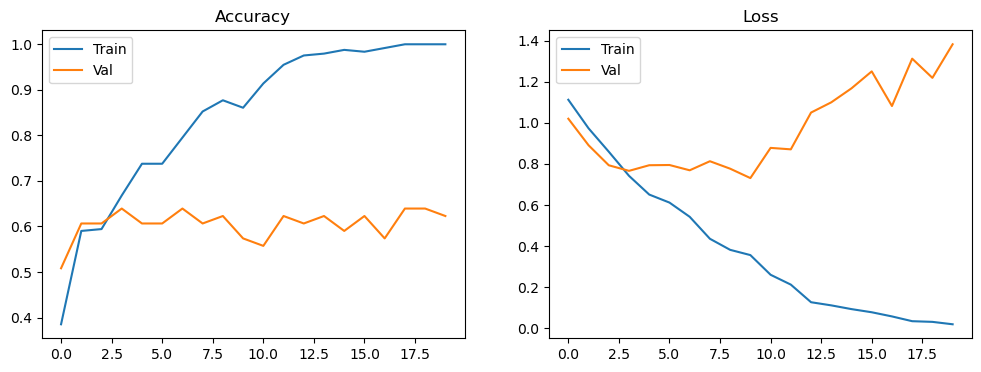

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6871 - loss: 1.3767
Test Accuracy: 0.6870748400688171
Test Loss: 1.376662015914917


In [13]:
preds = model.predict(X_test)
pred_classes = np.argmax(preds, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [14]:
print(classification_report(y_test, pred_classes, target_names=classes))

                       precision    recall  f1-score   support

    Baroque paintings       0.75      0.66      0.70        58
         Medieval art       0.79      0.92      0.85        52
Renaissance paintings       0.43      0.41      0.42        37

             accuracy                           0.69       147
            macro avg       0.65      0.66      0.65       147
         weighted avg       0.68      0.69      0.68       147



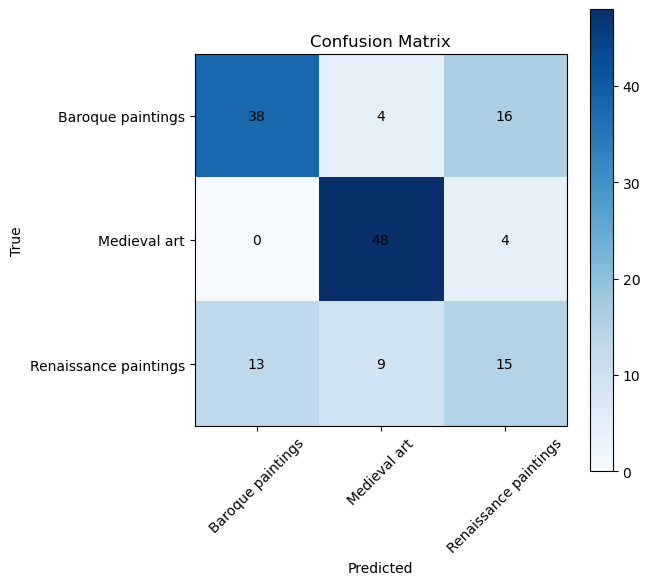

In [15]:
cm = confusion_matrix(y_test, pred_classes)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
model.save("painting_era_cnn.h5")
